In [1]:
# 数据处理
import pandas as pd
import numpy as np

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns

# 日期处理
from datetime import datetime

# 设置默认样式
sns.set(style='whitegrid')
%matplotlib inline


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import pandas as pd

# 设置数据路径
file_path = '/content/drive/My Drive/datasets/7004/nyc_taxi_part_1_with_coords.csv'

# 可选：设定读取的列（如只需要部分列可提高速度）
cols_to_use = [
    'tpep_pickup_datetime', 'tpep_dropoff_datetime',
    'passenger_count', 'trip_distance',
    'pulocationid', 'fare_amount', 'tip_amount', 'total_amount',
    'pickup_lat', 'pickup_lon'
]


# 读取数据（如果内存吃紧可加 chunksize 分批处理）
df = pd.read_csv(file_path, usecols=cols_to_use, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

# 查看加载情况
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9885535 entries, 0 to 9885534
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   passenger_count        float64       
 3   trip_distance          float64       
 4   pulocationid           int64         
 5   fare_amount            float64       
 6   tip_amount             float64       
 7   total_amount           float64       
 8   pickup_lat             float64       
 9   pickup_lon             float64       
dtypes: datetime64[ns](2), float64(7), int64(1)
memory usage: 754.2 MB


In [5]:
# 提取小时字段
df['hour'] = df['tpep_pickup_datetime'].dt.hour

# 提取星期（0=Monday, 6=Sunday）
df['weekday'] = df['tpep_pickup_datetime'].dt.weekday

# 分类为工作日 or 周末
df['day_type'] = df['weekday'].apply(lambda x: 'Weekday' if x < 5 else 'Weekend')


In [6]:
# 每小时订单量
hourly_trip_count = df.groupby(['day_type', 'hour']).size().reset_index(name='trip_count')


In [7]:
hourly_avg_distance = df.groupby(['day_type', 'hour'])['trip_distance'].mean().reset_index(name='avg_distance')

# 合并结果
hourly_stats = pd.merge(hourly_trip_count, hourly_avg_distance, on=['day_type', 'hour'])


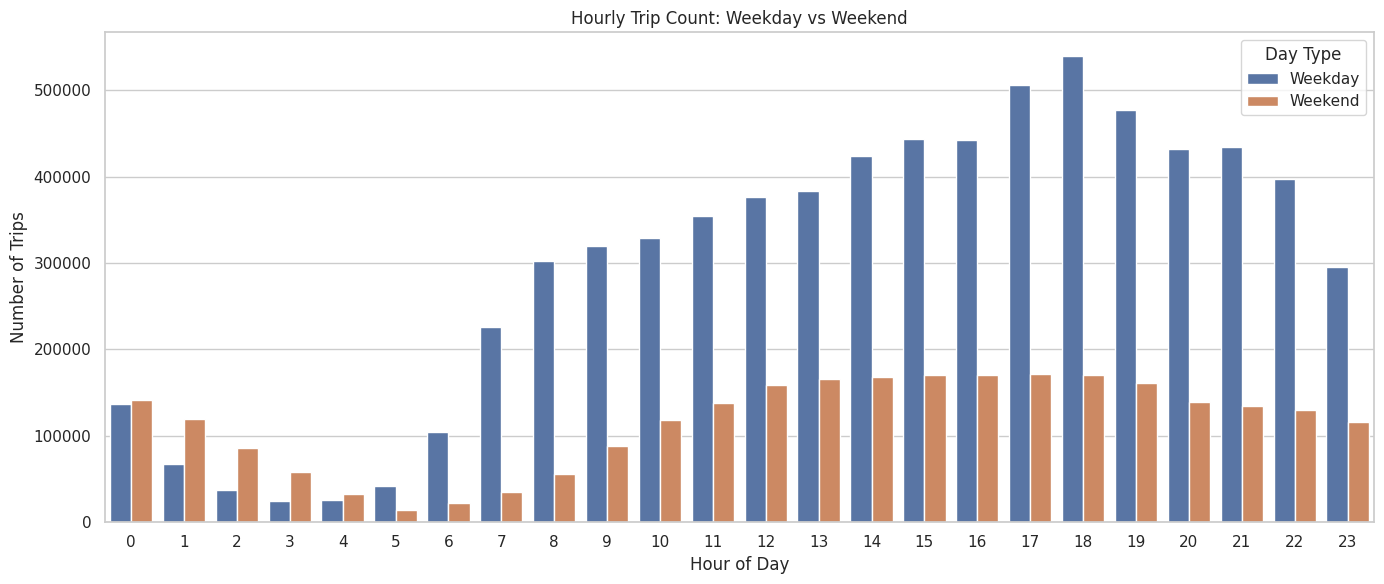

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
sns.barplot(data=hourly_stats, x='hour', y='trip_count', hue='day_type')
plt.title('Hourly Trip Count: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.legend(title='Day Type')
plt.tight_layout()
plt.show()


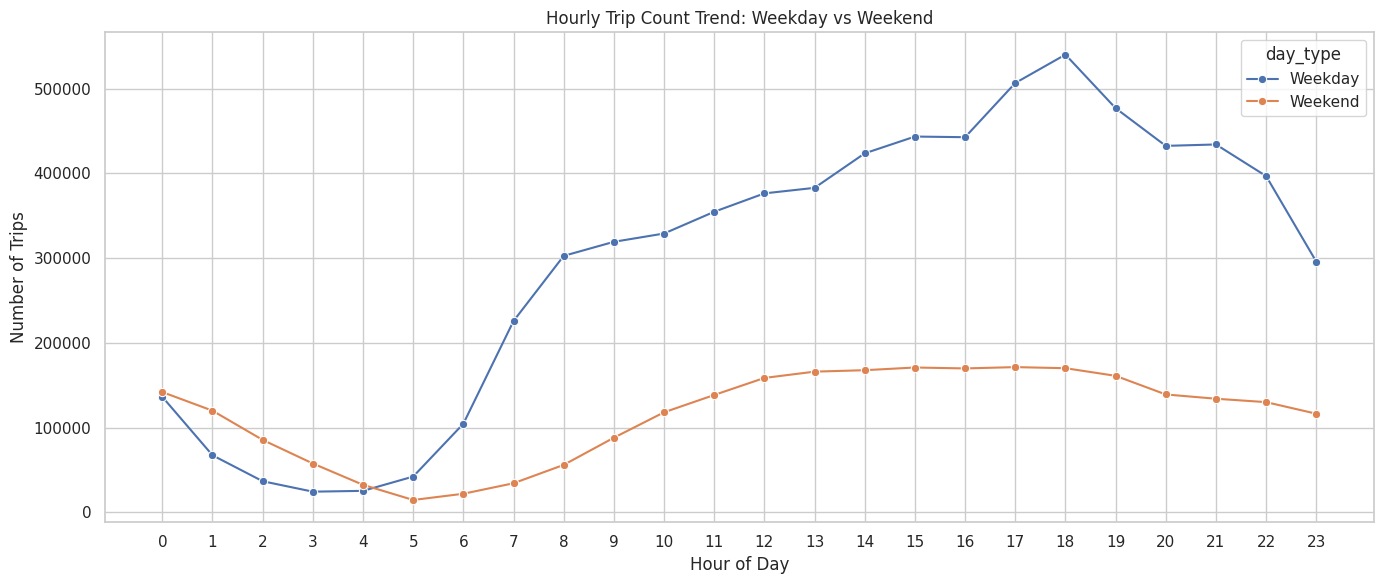

In [9]:
# 折线图版本（强调趋势）
plt.figure(figsize=(14,6))
sns.lineplot(data=hourly_stats, x='hour', y='trip_count', hue='day_type', marker='o')
plt.title('Hourly Trip Count Trend: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


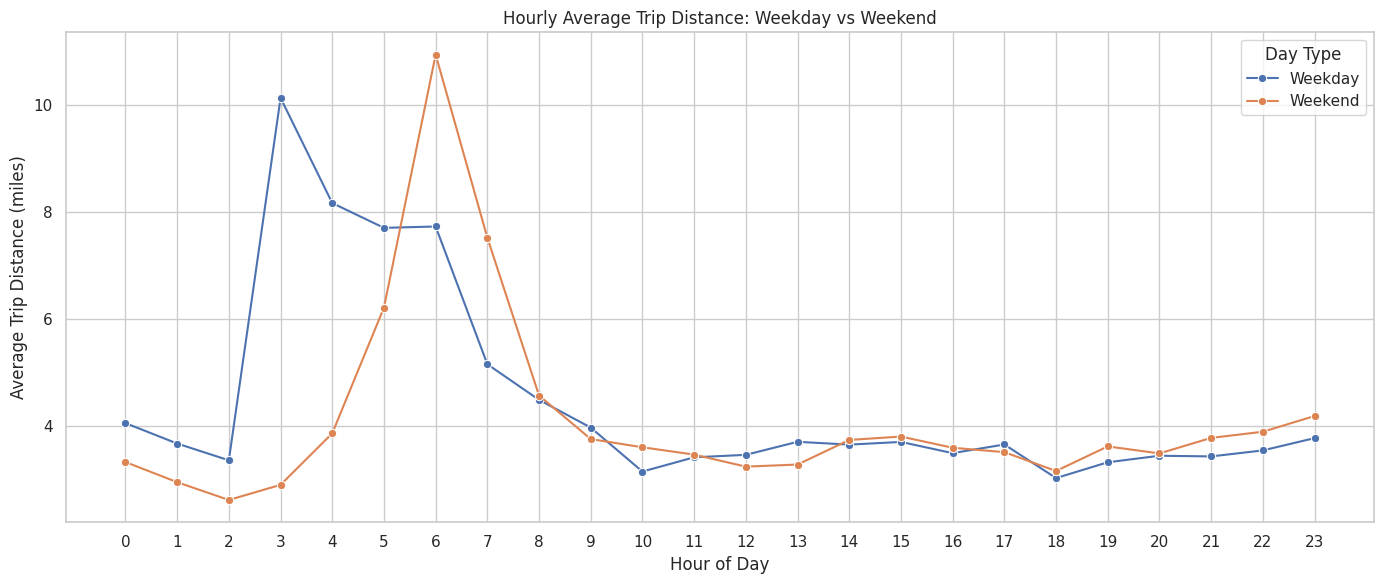

In [10]:
plt.figure(figsize=(14,6))
sns.lineplot(data=hourly_stats, x='hour', y='avg_distance', hue='day_type', marker='o')
plt.title('Hourly Average Trip Distance: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Average Trip Distance (miles)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title='Day Type')
plt.tight_layout()
plt.show()


In [12]:
!pip install folium


In [13]:
import folium
from folium.plugins import HeatMap

def plot_heatmap_latlon(df, hour, day_type=None, sample_frac=0.1, zoom_start=11):
    """
    使用 pickup_lat/lon 绘制指定小时的上车热力图

    参数：
    - df: 含有 'pickup_lat', 'pickup_lon', 'hour', 'day_type' 的 DataFrame
    - hour: 要分析的小时（int 0~23）
    - day_type: 可选，'Weekday' 或 'Weekend'，默认None表示全体
    - sample_frac: 抽样比例，默认 10%，用于加快可视化渲染
    - zoom_start: 地图初始缩放等级，默认 11

    输出：
    - folium 热力图
    """

    # 数据筛选
    df_sub = df[df['hour'] == hour]
    if day_type:
        df_sub = df_sub[df_sub['day_type'] == day_type]

    # 去除缺失或经纬度无效数据
    df_sub = df_sub.dropna(subset=['pickup_lat', 'pickup_lon'])
    df_sub = df_sub[(df_sub['pickup_lat'] > 35) & (df_sub['pickup_lat'] < 45) &
                    (df_sub['pickup_lon'] > -80) & (df_sub['pickup_lon'] < -70)]

    # 抽样以提高渲染速度
    df_sample = df_sub.sample(frac=sample_frac, random_state=42)

    # 创建地图（中心点设为曼哈顿中部）
    m = folium.Map(location=[40.75, -73.97], zoom_start=zoom_start)

    # 添加热力图层
    heat_data = list(zip(df_sample['pickup_lat'], df_sample['pickup_lon']))
    HeatMap(heat_data, radius=8).add_to(m)

    return m


In [17]:
# 晚上22点，周末
map_22_weekend = plot_heatmap_latlon(df, hour=22, day_type='Weekend', sample_frac=0.3)

map_22_weekend


In [18]:
# 工作日上午8点
map_8_weekday = plot_heatmap_latlon(df, hour=8, day_type='Weekday', sample_frac=0.5)
map_8_weekday
